In [1]:
import numpy as np
import os


from lmfit.models import GaussianModel,Model
from sklearn.linear_model import LinearRegression
from sklearn import mixture,metrics

# нужно предварительно установить geos
# pip install geos
from shapely.geometry import Polygon  

from scipy.stats.distributions import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

    
from matplotlib import pyplot as plt
from matplotlib import cm

from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

from scipy import ndimage as ndi
from scipy.spatial import ConvexHull
from scipy.spatial import distance
from numpy import linalg 

from skimage import io
from skimage.draw import ellipse
from skimage.color import rgb2gray
from skimage import filters
from skimage.morphology import disk

from PIL import Image, ImageDraw, ImageFilter,ImageOps
import copy
import cv2

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import distance_transform_edt as edt
from skimage.draw import ellipse
from skimage.measure import find_contours, approximate_polygon,subdivide_polygon

from radio_beam.commonbeam import getMinVolEllipse


from utils import grainPreprocess,grainShow,grainMark,grainDraw,grainApprox,grainStats,grainMorphology


In [ ]:
home_path = os.getcwd()
images_folders_path=os.path.join(home_path,'data')

folders_names=os.listdir(images_folders_path)
folders_paths=[os.path.join(images_folders_path,folder) for folder in folders_names]
images_paths_raw=[os.listdir(folder_path) for folder_path in folders_paths]

images_paths=[]
for i,image_line in enumerate(images_paths_raw):
    images_paths.append([])
    for path in image_line:
        images_paths[i].append(os.path.join(folders_paths[i],path))


In [ ]:
c6_2_names=images_paths[3]
#c6_2_images=[grainPreprocess.image_preprocess(Image.open(name),h=150,k=1) for i,name in enumerate(c6_2_names) if i<=20]
#c6_2_images_km=[grainPreprocess.image_preprocess_kmeans(Image.open(name),h=150,k=1) for i,name in enumerate(c6_2_names) if i<=20]

In [2]:
def img_load_preprocess(path,names,h=150,k=1):
    imgs_path=[path+'/'+name for name in names]
    imgs=[]
    for img_path in imgs_path:
        img=io.imread(img_path)
        img=grainPreprocess.image_preprocess(img,h,k)
        imgs.append(img)
    return imgs

In [3]:
path='images'
grain_names=['Ultra_Co8.jpg','Ultra_Co11.jpg','Ultra_Co6_2.jpg','Ultra_Co15.jpg','Ultra_Co25.jpg']
grain_images=img_load_preprocess(path,grain_names)

D:\PROJECTS\python\grain_segmentation\utils.py:61: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img=rgb2gray(gray)


In [4]:
def angles_approx(images,names,types,step,N,font_size=20):
    #
    # хорошая аппроксимация , вывод трех распределений
    #
    texts=[]
    gaussians=[]
    scatters_x=[]
    scatters_y=[]
    max_prob=0
    for j,image in enumerate(images):
        
        original_angles=grainMark.get_angles(image)
        angles,angles_set,dens_curve=grainStats.stats_preprocess(original_angles,step)
        
        max_val=max(dens_curve)
        x = np.array(angles_set)
        y = np.array(dens_curve)

        norm=np.sum(y)
        if max_val/norm>max_prob:
            max_prob=max_val/norm
        
        mus2,sigmas2,amps2=grainApprox.gaussian_fit_bimodal(y,x)
   

        x_gauss=range(0,361)
        
        gauss=grainStats.gaussian_bimodal(x_gauss,mus2[0],mus2[1],sigmas2[0],sigmas2[1],amps2[0],amps2[1])
        
        gaussians.append(gauss/norm)
        scatters_x.append(x)
        scatters_y.append(y/norm)
        
        mu1=round(mus2[0],2)
        sigma1=round(sigmas2[0],2)
        amp1=round(amps2[0]/norm,2)
        
        mu2=round(mus2[1],2)
        sigma2=round(sigmas2[1],2)
        amp2=round(amps2[1]/norm,2)
        
        x_gauss1=np.linspace(mu1-sigma1*3,mu1+sigma1*3,100)
        x_gauss2=np.linspace(mu2-sigma2*3,mu2+sigma2*3,100)


        gauss1=grainStats.gaussian(x_gauss1,mu1,sigma1,amp1)
        gauss2=grainStats.gaussian(x_gauss2,mu2,sigma2,amp2)
        
        val=round(norm,4)
        total_number='\n количество углов '+str(val)
        text_angle='\n шаг угла '+str(step)+' градусов'
        
        moda1='\n mu1 = '+str(mu1)+' sigma1 = '+str(sigma1)+' amp1 = '+str(amp1)
        moda2='\n mu2 = '+str(mu2)+' sigma2 = '+str(sigma2)+' amp2 = '+str(amp2)

        text=names[j][-20:]+types[j]+total_number+text_angle+moda1+moda2
        
        texts.append(text)
        
       
    plt.figure(figsize=(4,6))
    plt.rcParams['font.size'] = '20'
    
    plt.plot(gaussians[0])
    plt.plot(gaussians[1])
    plt.plot(gaussians[2])

    plt.scatter(scatters_x[0],scatters_y[0])
    plt.scatter(scatters_x[1],scatters_y[1],marker='v')
    plt.scatter(scatters_x[2],scatters_y[2],marker='s')
    
 #   plt.legend(texts,fontsize=font_size)
    plt.ylabel('p(x)', fontsize=font_size)
    plt.xlabel('угол связующего вещества, градусы', fontsize=font_size)

    plt.ylim([0, max_prob])
#    ax3.set_xlim([0, 360])

    print(texts)


    plt.savefig('распределение углов')
    plt.show()

D:\PROJECTS\python\grain_segmentation\utils.py:431: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  contours=np.array(contours)


['Ultra_Co8.jpgмелкие зерна\n количество углов 3968\n шаг угла 5 градусов\n mu1 = 114.46 sigma1 = 26.63 amp1 = 3.9\n mu2 = 237.8 sigma2 = 24.46 amp2 = 0.96', 'Ultra_Co11.jpg средние зерна\n количество углов 1909\n шаг угла 5 градусов\n mu1 = 114.34 sigma1 = 30.63 amp1 = 3.58\n mu2 = 227.99 sigma2 = 21.21 amp2 = 1.2', 'Ultra_Co6_2.jpg крупные зерна\n количество углов 1211\n шаг угла 5 градусов\n mu1 = 111.57 sigma1 = 33.45 amp1 = 3.26\n mu2 = 236.7 sigma2 = 28.32 amp2 = 1.51']


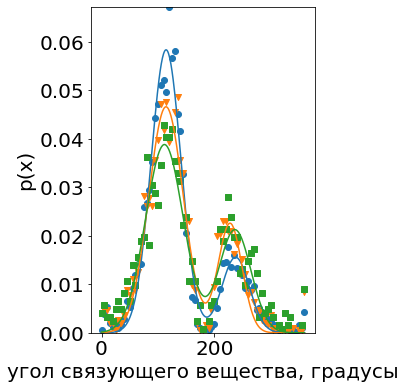

In [5]:
N=10

#images=[image1,image2,image3,image4,image5]
#origs=[grain1_pil,grain2_pil,grain3_pil,grain4_pil,grain5_pil]
#images=[image1km]
#images_true=[image1 ]
step=5
#names=[grain1_name,grain2_name,grain3_name,grain4_name,grain5_name]
#names=['сплав с крупными зернами']
#p=10
#angles_approx(c6_2_images[:p],c6_2_images[:p],c6_2_names[:p],step,N)
#angles_approx(images,images_true,names,step,N)
#angles_approx_metrics(c6_2_images,c6_2_images_km,c6_2_names,step,N)


images=grain_images[:3]
names=grain_names[:3]
types=['мелкие зерна',' средние зерна',' крупные зерна']
angles_approx(images,names,types,step,N)

## Распределение диаметров

https://radio-beam.readthedocs.io/en/latest/api/radio_beam.commonbeam.getMinVolEllipse.html#radio_beam.commonbeam.getMinVolEllipse

In [9]:
def diametr_approx(images,names,types,step,pixel,N,M):
    texts1=[]
    texts2=[]
    
    x_val1=[]
    y_val1=[]
    
    x_val2=[]
    y_val2=[]
    
    x_predict1=[]
    y_predict1=[]
    
    x_predict2=[]
    y_predict2=[]
    
    for j,image in enumerate(images):

        a_beams,b_beams,angles,cetroids=grainMark.get_mvee_params(image,0.2)
        
        distances1,dist1_set,dens1_curve=grainStats.stats_preprocess(a_beams,step)
        distances2,dist2_set,dens2_curve=grainStats.stats_preprocess(b_beams,step)
        angles,angles_set,angles_dens_curve=grainStats.stats_preprocess(np.rad2deg(angles).astype('int32'),step=5)

        norm1=round(np.sum(dens1_curve),6)
        norm2=round(np.sum(dens2_curve),6)
        
        
        x1 = np.array([dist1_set]).reshape(-1, 1)*pixel
        y1 = np.log([dens1_curve/norm1]).reshape(-1, 1)
        
        x2 = np.array([dist2_set]).reshape(-1, 1)*pixel
        y2 = np.log([dens2_curve/norm2]).reshape(-1, 1)
        

        
        x1=x1[2:-3]
        y1=y1[2:-3]
        
        x2=x2[2:-3]
        y2=y2[2:-3]
        
        xy1=np.concatenate([x1, y1],axis=1)
        xy2=np.concatenate([x2, y2],axis=1)
    
        x1=xy1[:,0].reshape(-1, 1)
        y1=xy1[:,1].reshape(-1, 1)
        x2=xy2[:,0].reshape(-1, 1)
        y2=xy2[:,1].reshape(-1, 1)
        

        
        x_linear1=np.linspace(x1.min(axis=0),x1.max(axis=0),50).reshape(-1, 1)
        x_linear2=np.linspace(x2.min(axis=0),x2.max(axis=0),50).reshape(-1, 1)
        
        reg1 = LinearRegression().fit(x1,y1)
        reg2 = LinearRegression().fit(x2,y2)
        
        lin_predict1=reg1.predict(x_linear1)
        lin_predict2=reg2.predict(x_linear2)
        
        
        k1=reg1.coef_[0][0]
        k2=reg2.coef_[0][0]
        
        b1=reg1.predict([[0]])[0][0]
        b2=reg2.predict([[0]])[0][0]
        
        
        angle1=round(np.rad2deg(np.arctan(k1)),4)
        angle2=round(np.rad2deg(np.arctan(k2)),4)
        
        score1=round(reg1.score(x1, y1),2)
        score2=round(reg2.score(x2, y2),2)
        
        val=pixel*step
            
        num1='\n количество регионов связ. в-ва  '+str(norm1)
        lin_k1='\n коэффициент k '+str(round((k1),3))
        lin_k1_angle='\n угол наклона '+str(angle1)+' градусов, сдвиг b '+str(round(b1,4))
        acc1='\n точность '+str(score1)
        text_step1='\n шаг длины диаметра '+str(val)+'$ мкм$'
        mean_text1='\nсреднее значение длины '+str(round(distances1.mean()*pixel,4))
        text1=names[j]+types[j]+lin_k1+ lin_k1_angle+acc1+num1+text_step1+mean_text1
    #    text1=names[j]+types[j]
        

        num2='\n количество регионов связ. в-ва '+str(norm1)
        lin_k2='\n коэффициент k '+str(round((k2),3))
        lin_k2_angle='\n угол наклона '+str(angle2)+' градусов'+' градусов, сдвиг b '+str(round(b2,4))
        acc2='\n точность '+str(score2)
        text_step2='\n шаг длины диаметра '+str(val)+'$ мкм$'
        mean_text2='\nсреднее значение длины '+str(round(distances2.mean()*pixel,4))
        text2=names[j]+types[j]+lin_k2+lin_k2_angle+acc2+num2+text_step2+mean_text2
      #  text2=names[j]+types[j]
        
        texts1.append(text1)
        texts2.append(text2)
        
        x_val1.append(x1)
        y_val1.append(y1)
        
        x_val2.append(x2)
        y_val2.append(y2)
        
        x_predict1.append(x_linear1)
        y_predict1.append(lin_predict1)
        
        x_predict2.append(x_linear2)
        y_predict2.append(lin_predict2)
        
    plt.rcParams['font.size'] = '15'
    gs = gridspec.GridSpec(2, 1)
    # для статьи 12,18
    plt.figure(figsize=(N,M))

    ax3 = plt.subplot(gs[0]) # row 1, span all columns
    
  #  ax3.grid()
    ax3.plot(x_predict1[0],y_predict1[0])
    ax3.plot(x_predict1[1],y_predict1[1])
    ax3.plot(x_predict1[2],y_predict1[2])
    
    ax3.scatter(x_val1[0],y_val1[0])
    ax3.scatter(x_val1[1],y_val1[1],marker='v')
    ax3.scatter(x_val1[2],y_val1[2],marker='s')
    
  #  ax3.legend(texts1,fontsize=14,loc=1)
   # ax3.set_title('распределение a-полуосей связующего вещества', fontsize=15)
    ax3.set_ylabel('ln(p(x))', fontsize=15)
    ax3.set_xlabel('длина полуоси, мкм', fontsize=15)

    ax4 = plt.subplot(gs[1]) # row 1, span all columns
    
  #  ax4.grid()
    ax4.plot(x_predict2[0],y_predict2[0])
    ax4.plot(x_predict2[1],y_predict2[1])
    ax4.plot(x_predict2[2],y_predict2[2])
    
    ax4.scatter(x_val2[0],y_val2[0])
    ax4.scatter(x_val2[1],y_val2[1],marker='v')
    ax4.scatter(x_val2[2],y_val2[2],marker='s')
    
#    ax4.legend(texts2,fontsize=14,loc=1)
  #  ax4.set_title('распределение b-полуосей связующего вещества', fontsize=15)
    ax4.set_ylabel('ln(p(x))', fontsize=15)
    ax4.set_xlabel('длина полуоси, мкм', fontsize=15)
    print(texts1)
    print(texts2)


  #  plt.savefig('распределение полуосей')
    plt.show()

        

D:\PROJECTS\python\grain_segmentation\utils.py:431: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  contours=np.array(contours)
D:\PROJECTS\python\grain_segmentation\utils.py:517: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data=np.array(data)
D:\PROJECTS\python\grain_segmentation\utils.py:431: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

['Ultra_Co8.jpgмелкие зерна\n коэффициент k -3.025\n угол наклона -71.7077 градусов, сдвиг b 0.558\n точность 1.0\n количество регионов связ. в-ва  757\n шаг длины диаметра 0.2485$ мкм$\nсреднее значение длины 0.586', 'Ultra_Co11.jpg средние зерна\n коэффициент k -1.784\n угол наклона -60.7313 градусов, сдвиг b -0.522\n точность 0.97\n количество регионов связ. в-ва  312\n шаг длины диаметра 0.2485$ мкм$\nсреднее значение длины 0.732', 'Ultra_Co6_2.jpg крупные зерна\n коэффициент k -1.069\n угол наклона -46.9013 градусов, сдвиг b -1.2935\n точность 0.88\n количество регионов связ. в-ва  172\n шаг длины диаметра 0.2485$ мкм$\nсреднее значение длины 0.9449']
['Ultra_Co8.jpgмелкие зерна\n коэффициент k -1.438\n угол наклона -55.1836 градусов градусов, сдвиг b -0.6297\n точность 0.94\n количество регионов связ. в-ва 757\n шаг длины диаметра 0.2485$ мкм$\nсреднее значение длины 0.9736', 'Ultra_Co11.jpg средние зерна\n коэффициент k -0.794\n угол наклона -38.4539 градусов градусов, сдвиг b -

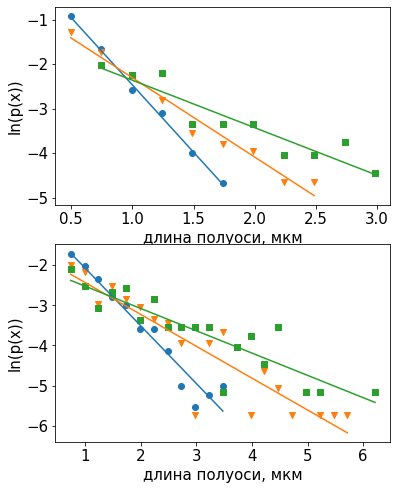

In [10]:
N=6
M=8
# для статье N=12,M=18
pixel=49.7/1000
#images=[image1,image2,image3,image4,image5]
#origs=[grain1_pil,grain2_pil,grain3_pil,grain4_pil,grain5_pil]
#images=[image2]
step=5

#names=[grain1_name,grain2_name,grain3_name,grain4_name,grain5_name]
#names=['сплав с крупными зернами']

#images=[image2,image3,image1]
#names=[grain2_name,grain3_name,grain1_name]
#types=[' мелкие зерна',' средние зерна',' крупные зерна']

#diametr_approx(origs,images,names,step,val1,val2,pixel,N)


images=grain_images[:3]
names=grain_names[:3]
types=['мелкие зерна',' средние зерна',' крупные зерна']

diametr_approx(images,names,types,step,pixel,N,M)